In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [3]:
from entot.data.data import create_gaussians, create_gaussian_split
from entot.plotting.plots import plot_1D
from entot.models.models import NoiseOutsourcingModel, KantorovichGapModel
from entot.models.utils import MixtureNormalSampler
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import scanpy as sc

In [5]:
adata = sc.read("../../../data/adata_pancreas_2019_processed.h5ad")

In [8]:
sc.pp.pca(adata, n_comps=10)

In [12]:
source = adata[adata.obs["day"]=="14.5"].obsm["X_pca"].copy()
target = adata[adata.obs["day"]=="15.5"].obsm["X_pca"].copy()

In [13]:
kg = KantorovichGapModel(epsilon=0.1, input_dim=10, iterations=5000)

In [15]:
kg(source, target)

 11%|█         | 530/5000 [5:01:15<42:20:49, 34.11s/it]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_270189/2662285941.py", line 1, in <module>
    kg(source, target)
  File "/home/dominikk/git_repos/entot/entot/models/models.py", line 625, in __call__
    batch["source"] = jnp.concatenate((source_batch, latent_batch), axis=-1)
  File "/home/dominikk/git_repos/entot/entot/models/models.py", line 665, in step_fn
  File "/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/jax/_src/traceback_util.py", line 166, in reraise_with_filtered_traceback
    return fun(*args, **kwargs)
  File "/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/jax/_src/api.py", line 737, in value_and_grad_f
    ans, vjp_py, aux = _vjp(
  File "/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/jax/_src/api.py", line 2263, in _vjp
    out_

In [8]:
sm.sample(jnp.array([0]))

Array([[-0.05483729],
       [ 0.50867844],
       [-0.47168592],
       [ 1.1080925 ],
       [ 0.03892179],
       [ 0.24962454],
       [ 0.25863102],
       [ 0.72369844],
       [-0.04085078],
       [ 0.23618563]], dtype=float32)

In [19]:
kg.metrics["total_loss"]

dict_keys(['total_loss', 'fitting_loss', 'kant_gap'])

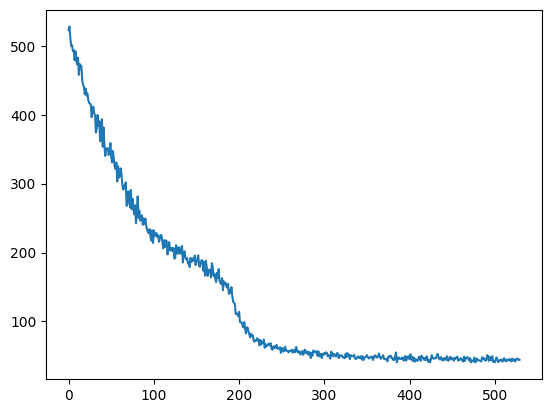

In [20]:
plt.plot(np.arange(len(kg.metrics["total_loss"])), kg.metrics["total_loss"])

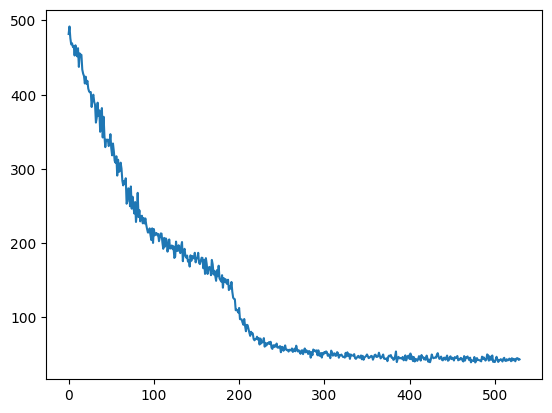

In [21]:
plt.plot(np.arange(len(kg.metrics["fitting_loss"])), kg.metrics["fitting_loss"])

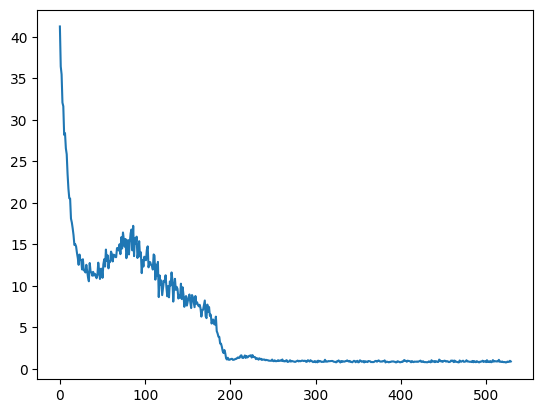

In [23]:
plt.plot(np.arange(len(kg.metrics["total_loss"])), kg.metrics["kant_gap"])

In [25]:
noise = jax.random.normal(jax.random.PRNGKey(0), shape=(len(source), 4))

In [26]:
source_with_noise = jnp.concatenate((source, noise), axis=1)

In [32]:
pushed = kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)

In [ ]:
sc.pp.neighbors()

In [34]:
bdata = adata.copy()
bdata.obsm["X_pca_result"] = np.concatenate((pushed, target), axis=0)

In [35]:
sc.pp.neighbors(bdata, use_rep="X_pca_result")

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/umap/d

In [36]:
sc.tl.umap(bdata)

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


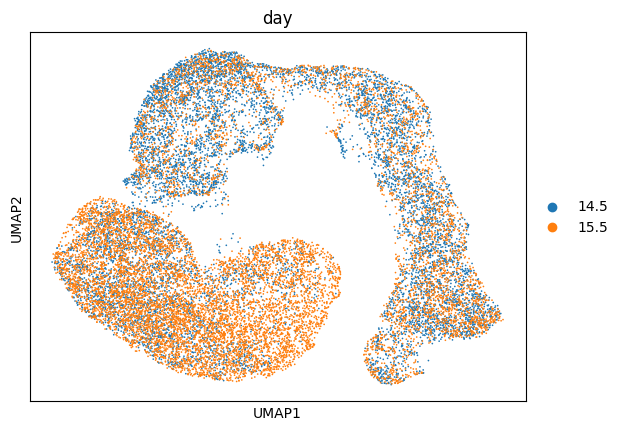

In [37]:
sc.pl.umap(bdata, color="day")

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


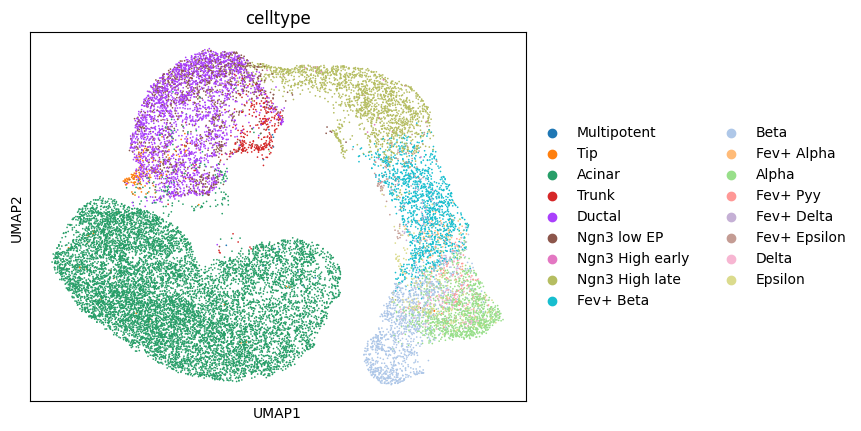

In [38]:
sc.pl.umap(bdata, color="celltype")

In [39]:
adata.obsm["X_pca_original"] = np.concatenate((source, target), axis=0)


In [40]:
sc.pp.neighbors(adata, use_rep="X_pca_original")

In [41]:
sc.tl.umap(adata)

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


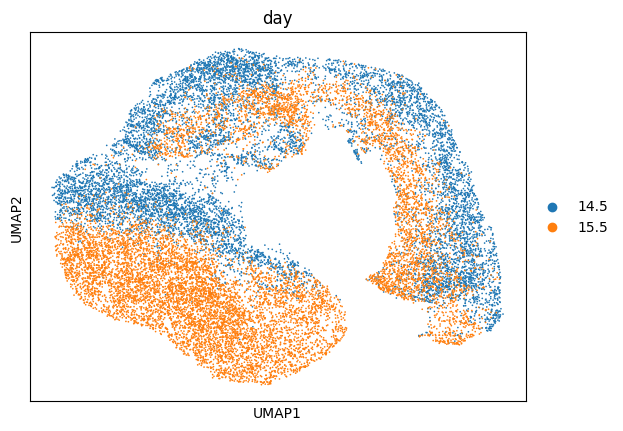

In [42]:
sc.pl.umap(adata, color="day")

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


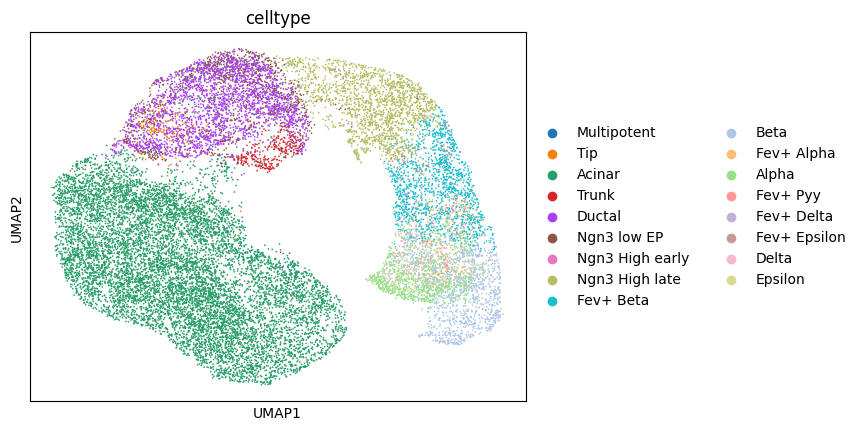

In [44]:
sc.pl.umap(adata, color="celltype")

In [48]:
res = [None] * 15

for i in range(15):
    noise = jax.random.normal(jax.random.PRNGKey(i), shape=(len(source), 4))
    source_with_noise = jnp.concatenate((source, noise), axis=1)
    res[i]= kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)


In [49]:
samples = jnp.array(res)

In [50]:
samples.shape

(15, 9633, 10)

In [51]:
vars = jnp.var(samples, axis=0)

In [53]:
vars_summed = jnp.sum(vars, axis=1)

In [71]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
bdata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

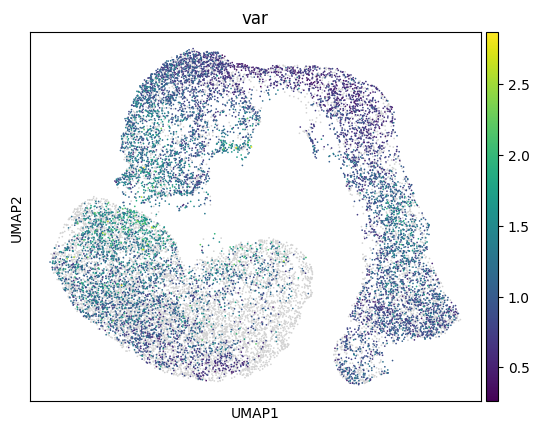

In [72]:
sc.pl.umap(bdata, color="var")

In [73]:
cdata = bdata[~bdata.obs["celltype"].isin(["Acinar", "Ductal", "Tip", "Trunk", "Multipotent", "Ngn3 low EP"])].copy()

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


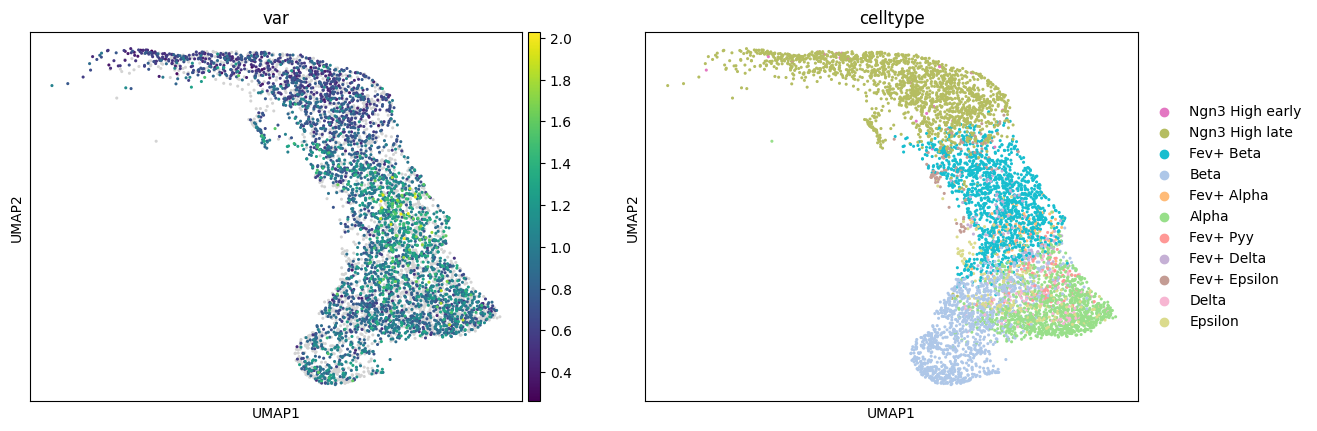

In [75]:
sc.pl.umap(cdata, color=["var", "celltype"])

In [76]:
sc.pp.neighbors(cdata, use_rep="X_pca_result")

In [77]:
sc.tl.umap(cdata)

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


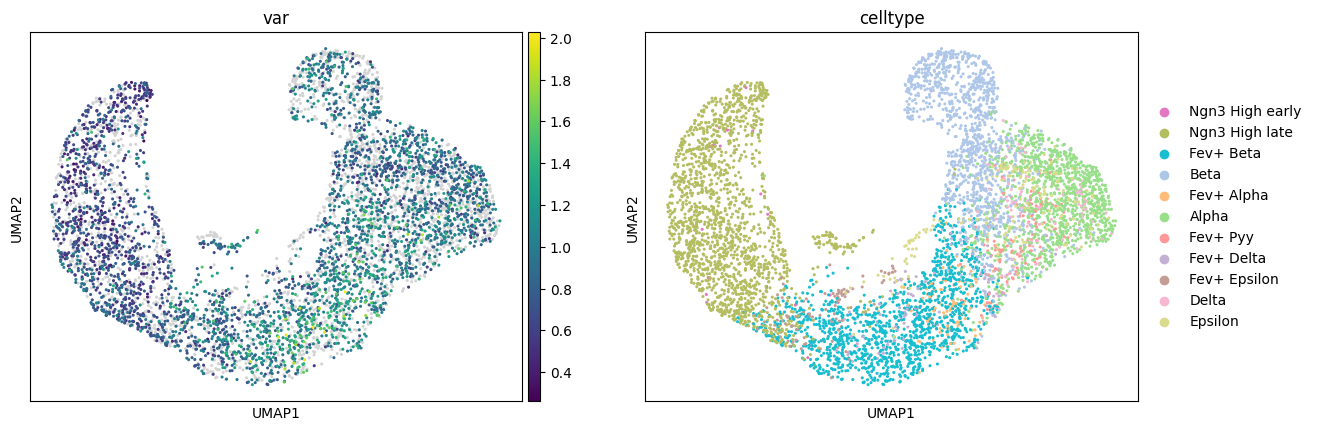

In [79]:
sc.pl.umap(cdata, color=["var", "celltype"])

Variance p(Y|X=0.5) is 0.10


<Axes: ylabel='Density'>

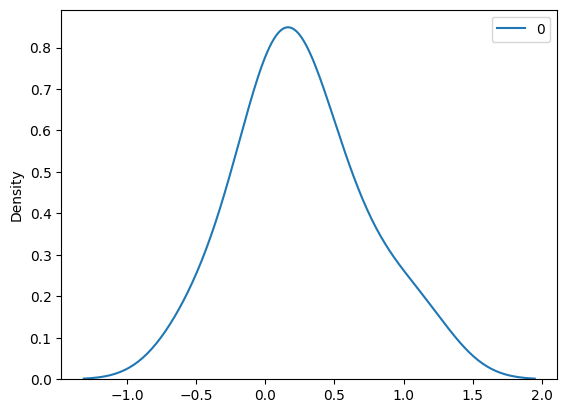

In [19]:
sample_05 = sm.sample(jnp.array([0.5]))
print(f"Variance p(Y|X=0.5) is {jnp.var(sample_05):.2f}")
sns.kdeplot(sample_0)